## Shrödinger Equation
### 

In [3]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.optim.lr_scheduler import StepLR
import os 
import numpy as np 
import shutil 
import matplotlib.pyplot as plt 
from pyDOE import lhs
import argparse
import scipy.io

In [4]:
class Problem(object): 
    """
    rewrite the problem;define its domain,
    """
    def __init__(self, domain=(0,np.pi/2,-5,5)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    def ic(self, x):
        x_=x.detach().cpu().numpy()
        f_ic=-2/np.cosh(x_[:,1])
        f_ic=f_ic.reshape(f_ic.size,1)
        return torch.from_numpy(f_ic).float()
    
    def true_value(self, t):
        data = scipy.io.loadmat('NLS.mat')
        x = data['x'].flatten()[:, None]
        Exact = data['uu']
        Exact_u = np.real(Exact)
        Exact_v = np.imag(Exact)
        t=400*t/np.pi
        t=np.int(t)
        ut = Exact_u[:,t]
        vt = Exact_v[:,t]
        ht=np.sqrt(ut**2+vt**2)
        ht=ht.reshape(ht.size,1)
        return ht

In [5]:
problem=Problem()
x=0.5*torch.ones((5,2))
y=problem.ic(x)
print(y)

tensor([[-1.7736],
        [-1.7736],
        [-1.7736],
        [-1.7736],
        [-1.7736]])


# Datasets

In [6]:
class Trainset(object):
    
    def __init__(self, *args, **kwargs):
        self.domain = (0,np.pi/2,-5,5)
        self.args = args
        self.method = kwargs['method']
        
    def __call__(self,verbose=None):
        if self.method == 'uniform':
            nx, nt, n_bc, n_ic = self.args[0], self.args[1], self.args[2], self.args[3]
            x, x_bc_left, x_bc_right, x_ic = self._uniform_sample(nx, nt, n_bc, n_ic)
        elif self.method == 'lhs':
            n, n_bc, n_ic = self.args[0], self.args[1], self.args[2]
            x, x_bc_left, x_bc_right, x_ic = self._lhs_sample(n, n_bc, n_ic)
            
        if verbose == 'tensor':
            x = torch.from_numpy(x).float()
            x_bc_left = torch.from_numpy(x_bc_left).float()
            x_bc_right = torch.from_numpy(x_bc_right).float()
            x_ic = torch.from_numpy(x_ic).float()
            return x, x_bc_left, x_bc_right, x_ic
        return x, x_bc_left, x_bc_right, x_ic
    def _uniform_sample(self, nx,nt, n_bc, n_ic):
        t_min, t_max, x_min, x_max = self.domain
        x = np.linspace(x_min,x_max,nx)
        t = np.linspace(t_min, t_max, nt)
        t, x = np.meshgrid(t, x)
        tx = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))
        
        t = np.linspace(t_min, t_max, n_bc)
        t, xl = np.meshgrid(t, x_min)
        x_bc_left = np.hstack((t.reshape(t.size, -1), xl.reshape(xl.size, -1)))
        t, xr = np.meshgrid(t, x_max)
        x_bc_right = np.hstack((t.reshape(t.size, -1), xr.reshape(xr.size, -1)))
        
        x = np.linspace(x_min,x_max,n_ic)
        t_ic, x = np.meshgrid(t_min, x)
        x_ic = np.hstack((t_ic.reshape(t_ic.size, -1), x.reshape(x.size, -1)))
        return tx, x_bc_left, x_bc_right, x_ic
    
    def _lhs_sample(self, n, n_bc, n_ic):
        t_min, t_max, x_min, x_max = self.domain
        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_max])
        x = lb + (ub - lb) * lhs(2, n)
        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_min])
        temp = lb + (ub - lb) * lhs(2, n_bc)
        x_bc_left = temp
        lb = np.array([t_min, x_max])
        ub = np.array([t_max, x_max])
        temp = lb + (ub - lb) * lhs(2, n_bc)
        x_bc_right = temp
        lb = np.array([t_min, x_min])
        ub = np.array([t_min, x_max])
        temp = lb + (ub - lb) * lhs(2, n_ic)
        x_ic = temp
        return x, x_bc_left, x_bc_right, x_ic

In [7]:
class Testset(object):
    """The dataset is based on a square domain
    """

    def __init__(self, *args, **kwargs):
        self.domain = (0,np.pi/2,-5,5)
        self.args = args
        self.method = kwargs['method']
        
    def __repr__(self):
        return f'{self.__doc__}'
    
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, t = self.args[0], self.args[1]
            X, x = self._uniform_sample(n_x, t)
        if verbose == 'tensor':
            X = torch.from_numpy(X).float()
        return X, x
    
    def _uniform_sample(self, n_x, t):
        t_min, t_max, x_min, x_max = self.domain
        x = np.linspace(x_min, x_max, n_x)
        t, x = np.meshgrid(t, x)
        X = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))
        return X, x

In [8]:
def activation(name):
    """define all the activation function
    """
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

In [9]:
def grad(outputs, inputs):
    """compute the derivative of outputs associated with inputs
       input: (N,D) tensors
       output:(N,1) tensors
    """
    return torch.autograd.grad(outputs, inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

## Network Archetecture
### DNN: Deep netral network

In [10]:
class DNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
    
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
    
    def forward(self, x):
        return self.model(x)
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

### Residual DNN

In [11]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, act_name='tanh'):
        super().__init__()
        
        assert(dim_in == dim_out)
        block = nn.Sequential()
        block.add_module('act0', activation(act_name))
        block.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        block.add_module('act1', activation(act_name))
        block.add_module('fc1', nn.Linear(dim_hidden, dim_out, bias=True))
        self.block = block
        
    def forward(self, x):
        identity = x
        out = self.block(x)
        return identity + out

In [12]:
class ResDNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name='tanh', init_name='kaiming_normal'):
        super().__init__()
        
        model = nn.Sequential()
        model.add_module('fc_first', nn.Linear(dim_in, dim_hidden, bias=True))
        for i in range(res_blocks):
            res_block = ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name=act_name)
            model.add_module(f'res_block{i+1}', res_block)
        model.add_module('act_last', activation(act_name))
        model.add_module('fc_last', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
        
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
              x = module(x)
              print(f"{name:<20}{str(x.shape):<40}")
        return x              
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

### Physics Informed Neural Networks (PINN)

In [13]:
class PINN(DNN):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers,act_name=act_name, init_name=init_name)
    def forward(self, x):
        x.requires_grad_(True)
        h= super().forward(x)
        a = torch.split(h, 1, dim=1)
        u = a[0]
        v = a[1]
        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [1]]
        u_t = grad_u[:, [0]]
        u_xx = grad(u_x, x)[0][:, [1]]
        grad_v = grad(v, x)[0]
        v_x = grad_v[:, [1]]
        v_t = grad_v[:, [0]]
        v_xx = grad(v_x, x)[0][:, [1]]
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u
        return u, v, u_x, v_x, f_u, f_v

In [14]:
class ResPINN(ResDNN):
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks,act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks,act_name=act_name, init_name=init_name)
    def forward(self,x):
        x.requires_grad_(True)
        h = super().forward(x)
        a = torch.split(h, 1, dim=1)
        u = a[0]
        v = a[1]
        grad_u = grad(u, x)[0]
        u_x = grad_u[:, [1]]
        u_t = grad_u[:, [0]]
        u_xx = grad(u_x, x)[0][:, [1]]
        grad_v = grad(v, x)[0]
        v_x = grad_v[:, [1]]
        v_t = grad_v[:, [0]]
        v_xx = grad(v_x, x)[0][:, [1]]
        f_u = u_t + 0.5*v_xx + (u**2+v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2+v**2)*u
        return u, v, u_x, v_x, f_u, f_v

#### Testing

In [15]:
x = torch.randn((200,2))
x_bc = torch.randn((20,2))
model = PINN(2, 2, 10, 8)
print(model)
u_pred,f_pred,zx,zz,a,b = model(x)
print(u_pred.shape, f_pred.shape)

PINN(
  (model): Sequential(
    (fc0): Linear(in_features=2, out_features=10, bias=True)
    (act0): Tanh()
    (fc1): Linear(in_features=10, out_features=10, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (act2): Tanh()
    (fc3): Linear(in_features=10, out_features=10, bias=True)
    (act3): Tanh()
    (fc4): Linear(in_features=10, out_features=10, bias=True)
    (act4): Tanh()
    (fc5): Linear(in_features=10, out_features=10, bias=True)
    (act5): Tanh()
    (fc6): Linear(in_features=10, out_features=10, bias=True)
    (act6): Tanh()
    (fc7): Linear(in_features=10, out_features=10, bias=True)
    (act7): Tanh()
    (fc8): Linear(in_features=10, out_features=2, bias=True)
  )
)
torch.Size([200, 1]) torch.Size([200, 1])


In [16]:
class Options(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=50, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=5000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=200, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler forAdam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='lhs', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_t', type=int, default=100, help='sample points in t-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')
        parser.add_argument('--n_ic', type=int, default=400, help='sample points on the initial time for lhs sample')
        self.parser = parser
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #choose the environment according to whether you have cuda or not.
    
        return arg


In [17]:
args = Options().parse()
print(args)

Namespace(cuda=False, device=device(type='cpu'), dim_hidden=50, epochs_Adam=5000, epochs_LBFGS=200, gamma=0.7, hidden_layers=4, lam=1, lr=0.001, n=10000, n_bc=400, n_ic=400, n_t=100, n_x=100, no_cuda=False, res_blocks=4, resume=False, sample_method='lhs', step_size=2000)


## Some measures to slove the problem
#### Redefine the function:
#### $$h=u+iv$$
#### $$iu_t-v_t+0.5u_xx+0.5iv_xx+(u^2+v^2)u+i(u^2+v^2)v$$
#### And in such function we have:
##### Actual part: $$-v_t+0.5u_xx+(u^2+V^2)u=0$$
##### Imaginary part: $$u_t+0.5v_xx+(u^2+v^2)v=0$$
### Origin
#### Make $$|h(0,x)|=2sech(x)$$
## Training Process

In [18]:
def save_model(state, is_best=None, save_dir=None): 
    """save the best and the last model
    """
    last_model = os.path.join(save_dir, 'last_model.pth.tar')  
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [19]:
class Trainer(object):
    def __init__(self, args): # args includs all paraments needed in the net
        self.device  = args.device  #cpu or gpu
        self.problem = args.problem
        
        self.lam = args.lam       # weight of the initial model
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)  # learning rate 
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), 
                                           max_iter=20, 
                                           tolerance_grad=1.e-8,
                                           tolerance_change=1.e-12)   # everytime a parement is updataed, an equation is solved and so there has to be a maxinum of the iteration
        self.lr_scheduler = StepLR(self.optimizer_Adam, 
                                   step_size=args.step_size, 
                                   gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x, self.x_bc_left, self.x_bc_right, self.x_ic = args.trainset(verbose='tensor')
        self.x_val, self.x_bc_left_val, self.x_bc_right_val, self.x_ic_val = args.validset(verbose='tensor')
        self.true_ic = args.problem.ic(self.x_ic)
        self.true_ic_val = args.problem.ic(self.x_ic_val)
        if self.device == torch.device(type='cuda'):
            self.x, self.x_bc_left, self.x_bc_right, self.x_ic = self.x.to(self.device), self.x_bc_left.to(self.device), self.x_bc_right.to(self.device), self.x_ic.to(self.device)
            self.x_val, self.x_bc_left_val, self.x_bc_right_val, self.x_ic_val = self.x_val.to(self.device), self.x_bc_left_val.to(self.device), self.x_bc_right_val.to(self.device), self.x_ic_val.to(self.device)
            self.true_ic, self.true_ic_val = self.true_ic.to(self.device), self.true_ic_val.to(self.device)
        
    def _model_path(self):
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
            #path = os.path.join('checkpoints', self.model_name, f'{args.dim_hidden}_{args.hidden_layers}')
        path = f'checkpoints/{self.model_name}_{args.dim_hidden}_{args.hidden_layers}'
        if not os.path.exists(path):
            os.mkdir(path)
        return path
    
    def train(self):
        best_loss = 1.e10
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2, loss3 = self.train_Adam()
            if (epoch + 1) % 100 == 0:
                # self.infos_Adam(epoch + 1, loss, loss1, loss2, loss3)
                nums.append(epoch + 1)
                losses.append(loss)
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
            if (epoch + 1) % 1000 == 0:
                self.infos_Adam(epoch + 1, loss, loss1, loss2, loss3)
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2, loss3 = self.train_LBFGS()
            if (epoch + 1) % 20 == 0:
                # self.infos_LBFGS(epoch + 1, loss, loss1, loss2, loss3)
                nums.append(epoch + 1)
                losses.append(loss)
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
            if (epoch + 1) % 50 == 0:
                self.infos_LBFGS(epoch + 1, loss, loss1, loss2, loss3)
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()
        _, _, _, _, f_u, f_v = self.model(self.x)
        u_bc_left, v_bc_left, ux_bc_left, vx_bc_left, _, _ = self.model(self.x_bc_left)
        u_bc_right, v_bc_right, ux_bc_right, vx_bc_right, _, _ = self.model(self.x_bc_right)
        u_ic, v_ic, _, _, _, _ = self.model(self.x_ic)
        h_ic=torch.sqrt(u_ic**2+v_ic**2)
        loss1 = self.criterion(f_u, torch.zeros_like(f_u)) + self.criterion(f_v, torch.zeros_like(f_v))
        loss2 = self.criterion(u_bc_left, u_bc_right) + self.criterion(v_bc_left, v_bc_right) + \
                self.criterion(ux_bc_left, ux_bc_right) + self.criterion(vx_bc_left, vx_bc_right)
        loss3 = self.criterion(u_ic, self.true_ic) + self.criterion(v_ic, torch.zeros_like(self.true_ic))
        loss = loss1 + loss2 + loss3
        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()
        return loss.item(), loss1.item(), loss2.item(), loss3.item()
    def infos_Adam(self, epoch, loss, loss1, loss2, loss3):
        infos = 'Adam ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} = {loss1:.4e} + {loss2:.4e} + {loss3:.4e} ' + \
                f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
    def train_LBFGS(self):
    # only used to compute loss_int and loss_bc1 for monitoring
        _, _, _, _, f_u, f_v = self.model(self.x)
        u_bc_left, v_bc_left, ux_bc_left, vx_bc_left, _, _ = self.model(self.x_bc_left)
        u_bc_right, v_bc_right, ux_bc_right, vx_bc_right, _, _ = self.model(self.x_bc_right)
        u_ic, v_ic, _, _, _, _ = self.model(self.x_ic)
        h_ic=torch.sqrt(u_ic**2+v_ic**2)
        loss1 = self.criterion(f_u, torch.zeros_like(f_u)) + self.criterion(f_v, torch.zeros_like(f_v))
        loss2 = self.criterion(u_bc_left, u_bc_right) + self.criterion(v_bc_left, v_bc_right) + \
                self.criterion(ux_bc_left, ux_bc_right) + self.criterion(vx_bc_left, vx_bc_right)
        loss3 = self.criterion(u_ic, self.true_ic) + self.criterion(v_ic, torch.zeros_like(self.true_ic))
       # loss3 = self.criterion(h_ic, self.true_ic)
        loss = loss1 + loss2 + loss3
        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, _, _, _, f_u, f_v = self.model(self.x)
            u_bc_left, v_bc_left, ux_bc_left, vx_bc_left, _, _ = self.model(self.x_bc_left)
            u_bc_right, v_bc_right, ux_bc_right, vx_bc_right, _, _ = self.model(self.x_bc_right)
            u_ic, v_ic, _, _, _, _ = self.model(self.x_ic)
            h_ic = torch.sqrt(u_ic ** 2 + v_ic ** 2)
            loss1 = self.criterion(f_u, torch.zeros_like(f_u)) + self.criterion(f_v, torch.zeros_like(f_v))
            loss2 = self.criterion(u_bc_left, u_bc_right) + self.criterion(v_bc_left, v_bc_right) + \
                    self.criterion(ux_bc_left, ux_bc_right) + self.criterion(vx_bc_left, vx_bc_right)
            loss3 = self.criterion(u_ic, self.true_ic) + self.criterion(v_ic, torch.zeros_like(self.true_ic))
            # loss3 = self.criterion(h_ic, self.true_ic)
            loss = loss1 + loss2 + loss3
            if loss.requires_grad:
                loss.backward()
            return loss
        self.optimizer_LBFGS.step(closure)
        loss = closure()
        return loss.item(), loss1.item(), loss2.item(), loss3
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2, loss3):
        infos = 'LBFGS ' + \
                f'Epoch #{epoch:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.2e} = {loss1:.2e} + {loss2:.2e} + {loss3:.2e}'
        print(infos)
    def validate(self, epoch):
        self.model.eval()
        _, _, _, _, f_u_val, f_v_val = self.model(self.x_val)
        u_bc_left_val, v_bc_left_val, ux_bc_left_val, vx_bc_left_val, _, _ = self.model(self.x_bc_left_val)
        u_bc_right_val, v_bc_right_val, ux_bc_right_val, vx_bc_right_val, _, _ = self.model(self.x_bc_right_val)
        u_ic_val, v_ic_val, _, _, _, _ = self.model(self.x_ic_val)
        h_ic_val = torch.sqrt(u_ic_val ** 2 + v_ic_val ** 2)
        loss1 = self.criterion(f_u_val, torch.zeros_like(f_u_val)) + self.criterion(f_v_val, torch.zeros_like(f_v_val))
        loss2 = self.criterion(u_bc_left_val, u_bc_right_val) + self.criterion(v_bc_left_val, v_bc_right_val) + \
                self.criterion(ux_bc_left_val, ux_bc_right_val) + self.criterion(vx_bc_left_val,vx_bc_right_val)
        loss3 = self.criterion(u_ic_val, self.true_ic) + self.criterion(v_ic_val, torch.zeros_like(self.true_ic))
        # loss3 = self.criterion(h_ic_val, self.true_ic_val)
        loss = loss1 + loss2 + loss3
        infos = 'Valid ' + \
                f'Epoch #{epoch + 1:5d}/{self.epochs_Adam + self.epochs_LBFGS} ' + \
                f'Loss: {loss:.4e} '
      # print(infos)
        self.model.train()
        return loss.item()

## Test Process 

In [20]:
class Tester(object):
    def __init__(self, args):
        self.device = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        # model_path = os.path.join('checkpoints',
        # model_name,
        # 'best_model.pth.tar')
        model_path = f'checkpoints/{model_name}_{args.dim_hidden}_{args.hidden_layers}/best_model.pth.tar'
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])
        self.model.to(self.device)
        self.X, self.x= args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    def predict(self,t):
        self.model.eval()
        u,v,_,_,_,_ = self.model(self.X)
        u = u.detach().cpu().numpy()
        u = u.reshape(self.x.shape)
        v = v.detach().cpu().numpy()
        v = v.reshape(self.x.shape)
        h=np.sqrt(u**2+v**2)
        truesln=self.problem.true_value(t)
        fig, axes = plt.subplots()
        axes.plot(self.x,h,label='Prediction')
        axes.plot(self.x,truesln,'--',label='Exact Solution')
        axes.legend()
        axes.set_title(f'Time = {t}')
        axes.set_xlabel('x')
        axes.set_ylabel('|h(t,x)|')
        fig.savefig(f't_{t:4f}.png')
        plt.show()
    def pred_result(self,t):
        self.model.eval()
        u,v,_,_,_,_ = self.model(self.X)
        u = u.detach().cpu().numpy()
        u = u.reshape(self.x.shape)
        v = v.detach().cpu().numpy()
        v = v.reshape(self.x.shape)
        h=np.sqrt(u**2+v**2)
        return self.x, h

# Results of the training based on different networks
## (1)PiNN
###### We first set network paraments as: dim_hidden=50,hidden_layers=4
###### Training paraments as: epochs_Adam=5000,epochs_LBFGS=200
###### The original learning-rate: lr=0.001
###### The changing speed of learning-rate: step_size=2000;gamma=0.7
###### Sampling of Training: 20000 nodes formed by Uniform Sampling (Boundary included)
###### Sampling of Testing: 20000 nodes formed by Uniform Sampling (Boundary included)

C:\Users\hs\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:369: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Adam Epoch # 1000/5200 Loss: 4.3233e-02 = 2.1976e-02 + 6.6482e-05 + 2.1190e-02 lr: 1.00e-03 
Adam Epoch # 2000/5200 Loss: 2.6659e-02 = 1.4046e-02 + 7.4657e-05 + 1.2539e-02 lr: 4.90e-04 
Adam Epoch # 3000/5200 Loss: 2.0465e-02 = 1.0639e-02 + 6.2251e-05 + 9.7640e-03 lr: 7.00e-04 
Adam Epoch # 4000/5200 Loss: 1.3408e-02 = 7.9810e-03 + 9.7790e-05 + 5.3291e-03 lr: 3.43e-04 
Adam Epoch # 5000/5200 Loss: 9.1044e-03 = 5.8412e-03 + 4.8556e-05 + 3.2147e-03 lr: 4.90e-04 
LBFGS Epoch # 5050/5200 Loss: 1.63e-04 = 1.47e-04 + 1.91e-06 + 2.03e-05
LBFGS Epoch # 5100/5200 Loss: 4.19e-05 = 3.45e-05 + 1.00e-06 + 7.03e-06
LBFGS Epoch # 5150/5200 Loss: 2.21e-05 = 1.66e-05 + 6.20e-07 + 5.19e-06
LBFGS Epoch # 5200/5200 Loss: 1.38e-05 = 9.63e-06 + 4.93e-07 + 3.81e-06


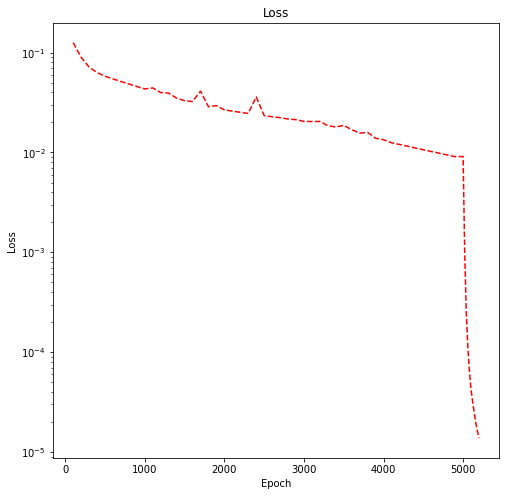

In [25]:
args = Options().parse()
args.problem = Problem()
args.model = PINN(2, 2, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
args.trainset = Trainset(200,100,args.n_bc,args.n_ic,method='uniform')
args.validset = Trainset(args.n_x, args.n_t, args.n_bc, args.n_ic, method='uniform')
nums = []
losses=[]
trainer = Trainer(args)
trainer.train()
loss_path=f'checkpoints/{args.model.__class__.__name__}_{args.dim_hidden}_{args.hidden_layers}/loss.txt'
np.savetxt(loss_path, np.vstack((nums, losses)).T)
fig, axes = plt.subplots(figsize=(8, 8))
axes.semilogy(nums, losses, 'r--')
axes.set_title('Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
plt.savefig('loss.png')

In [ ]:
###args = Options().parse()
#args.problem = Problem()
#args.model = PINN(2, 2, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers) t=0.59
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t) t=0.79
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t) t=0.98
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t)

## （2）Nesnet work

Adam Epoch # 1000/5200 Loss: 3.7051e-02 = 1.8659e-02 + 3.7753e-05 + 1.8354e-02 lr: 1.00e-03 
Adam Epoch # 2000/5200 Loss: 3.0462e-02 = 1.6129e-02 + 2.5557e-04 + 1.4078e-02 lr: 4.90e-04 
Adam Epoch # 3000/5200 Loss: 1.4111e-02 = 7.5054e-03 + 3.0872e-05 + 6.5750e-03 lr: 7.00e-04 
Adam Epoch # 4000/5200 Loss: 9.5620e-03 = 5.4202e-03 + 2.2915e-05 + 4.1189e-03 lr: 3.43e-04 
Adam Epoch # 5000/5200 Loss: 5.8782e-03 = 3.5918e-03 + 1.4437e-05 + 2.2719e-03 lr: 4.90e-04 
LBFGS Epoch # 5050/5200 Loss: 7.54e-05 = 7.13e-05 + 6.29e-07 + 6.10e-06
LBFGS Epoch # 5100/5200 Loss: 1.88e-05 = 1.60e-05 + 1.10e-07 + 2.97e-06
LBFGS Epoch # 5150/5200 Loss: 9.93e-06 = 7.32e-06 + 1.20e-07 + 2.60e-06
LBFGS Epoch # 5200/5200 Loss: 6.60e-06 = 4.42e-06 + 9.39e-08 + 2.14e-06


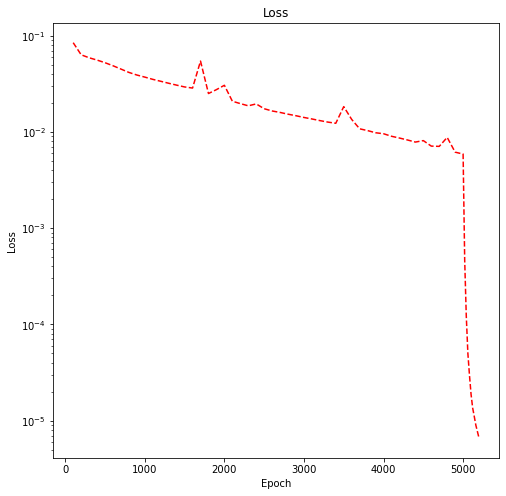

In [53]:
args = Options().parse()
args.problem = Problem()
# args.model = PINN(dim_in=2,
# dim_out=1,
# dim_hidden=args.dim_hidden,
# hidden_layers=args.hidden_layers,
# act_name='sin',
# dropout=args.dropout)
args.model = ResPINN(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.hidden_layers)
# args.trainset = Trainset(args.n, args.n_bc, args.n_ic, method='lhs')
args.trainset = Trainset(200, 100, args.n_bc, args.n_ic, method='uniform')
args.validset = Trainset(args.n_x, args.n_t, args.n_bc, args.n_ic, method='uniform')
nums = []
losses = []
trainer = Trainer(args)
trainer.train()
loss_path=f'checkpoints/{args.model.__class__.__name__}_{args.dim_hidden}_{args.hidden_layers}/loss.txt'
np.savetxt(loss_path, np.vstack((nums, losses)).T)
fig, axes = plt.subplots(figsize=(8, 8))
axes.semilogy(nums, losses, 'r--')
axes.set_title('Loss')
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')
plt.savefig('loss.png')

In [ ]:
#args = Options().parse()
#args.problem = Problem()
#args.model = ResPINN(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.hidden_layers) t=0.59
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t) t=0.79
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t) t=0.98
#args.testset = Testset(256, t, method='uniform')
#tester = Tester(args)
#tester.predict(t)